# Dependencies

In [1]:
import numpy as np
import pandas as pd 
import os
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
#from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
import keras.utils
from sklearn.model_selection import train_test_split
#import keras.applications.resnet50
WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 256
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

# Data Exploring

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

(3112,) (3112,) (550,) (550,)


<AxesSubplot:>

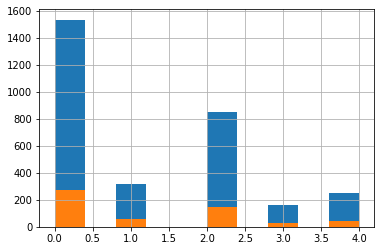

In [3]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

# Viewing Images

CPU times: total: 7.02 s
Wall time: 6.23 s


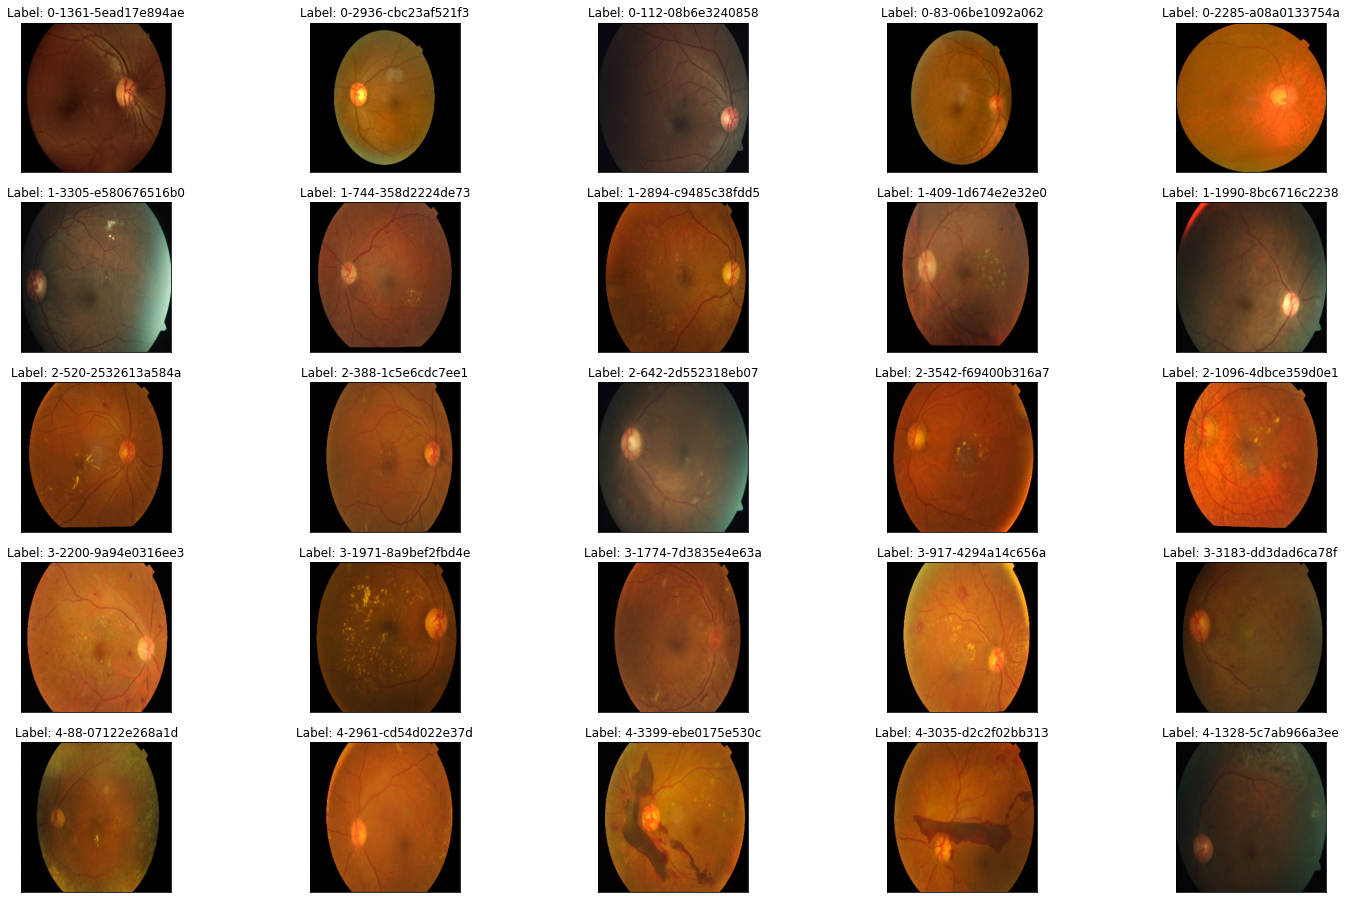

In [4]:
%%time
fig = plt.figure(figsize=(25, 16))
# display 5 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# Applying Grayscale

CPU times: total: 7.95 s
Wall time: 7.54 s


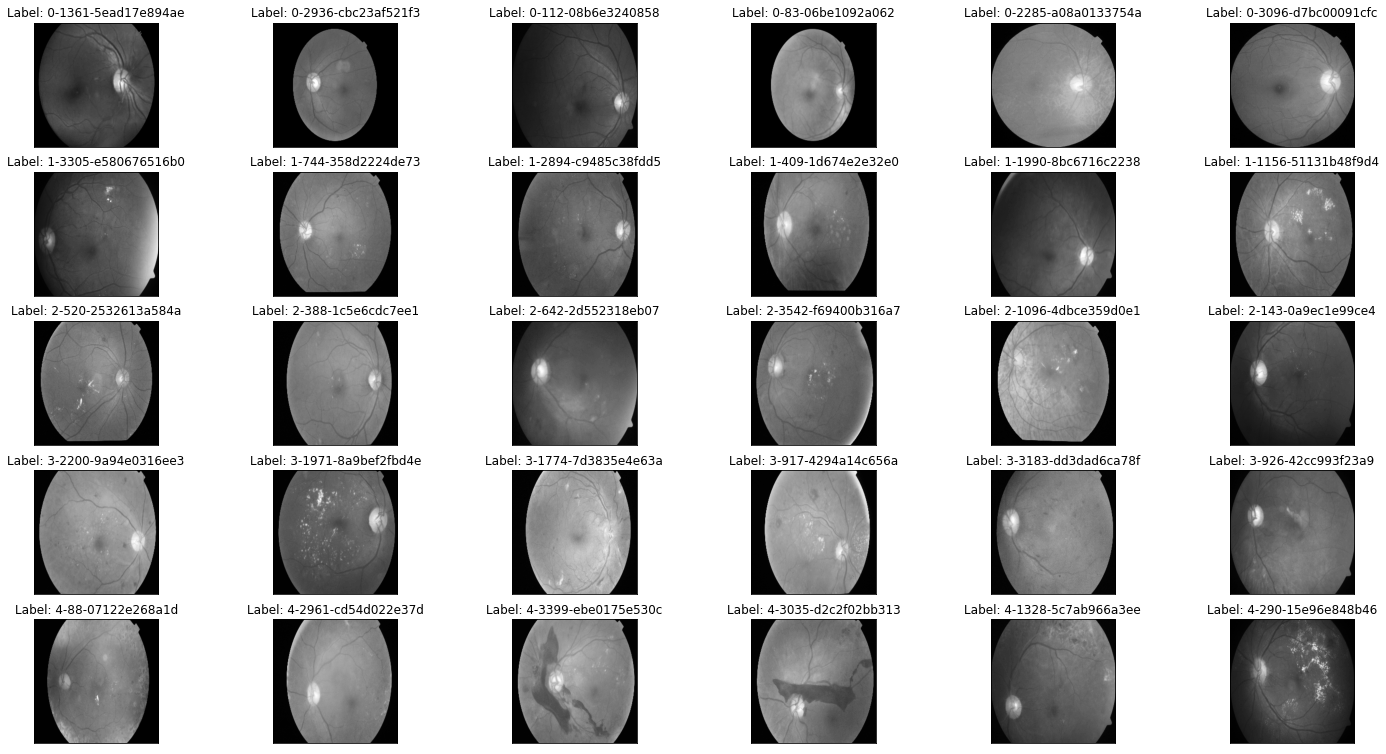

In [5]:
%%time
NUM_SAMP= 6
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(6, 6, class_id * 6 + i + 1, xticks=[], yticks=[])
        path=f"train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image=cv2.addWeighted ( image, 0 , cv2.GaussianBlur( image , (0 ,0 ) , 10) ,-4 ,128)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# Cropping images

In [6]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

# Applying gaussing blur

In [7]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

CPU times: total: 30.6 s
Wall time: 14.8 s


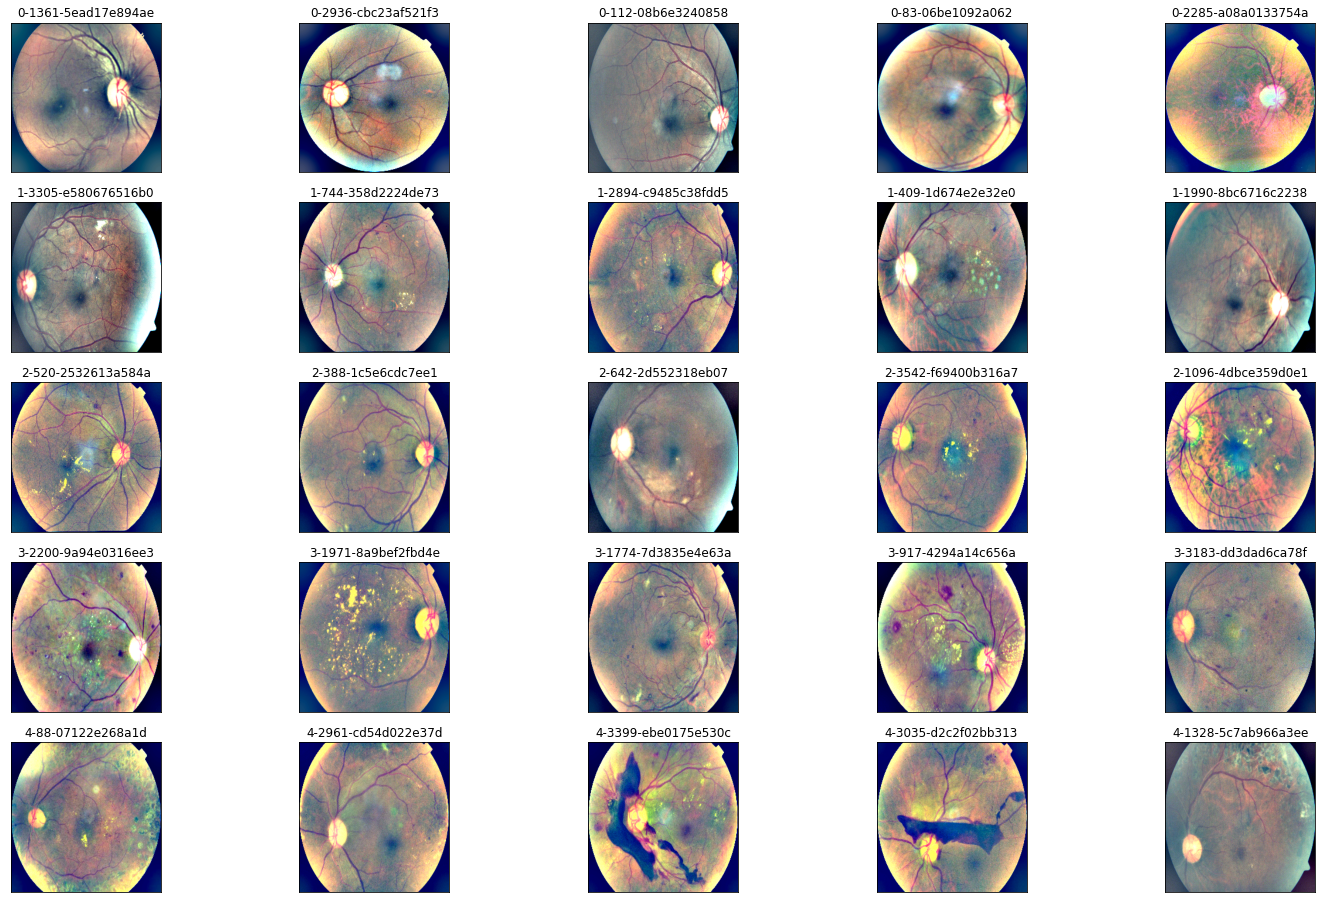

In [8]:
%%time

NUM_SAMP=5
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)
        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )
        #print('%d-%d-%s' ,class_id, idx, row['id_code'])

# Blood vessels Detection

In [9]:
#pip install opencv_jupyter_ui

In [10]:
#from opencv_jupyter_ui import cv2_imshow

In [11]:
def extract_bv(image):
    print("image")
    plt.imshow( image)
    plt.show()
    b,green_fundus,r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    print("green channel")
    plt.imshow(green_fundus)
    plt.show()
    contrast_enhanced_green_fundus = clahe.apply(green_fundus)
    print("clache")
    plt.imshow( contrast_enhanced_green_fundus)
    plt.show()
    # applying alternate sequential filtering (3 times closing opening)
    r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  
    r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
    r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
    f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
    print("morph 1")
    plt.imshow( R1)
    plt.show()
    print("morph 2")
    plt.imshow( R2)
    plt.show()
    print("morph 3")
    plt.imshow( R3)
    plt.show()
    print("substract from clache ")
    
    f5 = clahe.apply(f4)
    plt.imshow( f5)
    plt.show()
    # removing very small contours through area parameter noise removal
    ret,f6 = cv2.threshold(f5,5,255,cv2.THRESH_BINARY)
    mask = np.ones(f5.shape[:2], dtype="uint8") * 255
    contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

    
    for cnt in contours:

        if cv2.contourArea(cnt) <= 200:
            cv2.drawContours(mask, [cnt], -1, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=mask)
    ret,fin = cv2.threshold(im,5,255,cv2.THRESH_BINARY_INV)
    newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
    print("mask")
    plt.imshow( mask)
    plt.show()
    print("image without noise")
    plt.imshow( im)
    plt.show()
    print("image erosion")
    plt.imshow(newfin)
    plt.show()
    # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
    #vessels and also in an interval of area
    fundus_eroded = cv2.bitwise_not(newfin)
    xmask = np.ones(image.shape[:2], dtype="uint8") * 255
    xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in xcontours:
        shape = "unidentified"
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)   
        if len(approx) > 4 and cv2.contourArea(cnt) <= 600 and cv2.contourArea(cnt) >= 100:
            shape = "circle"
        else:
            shape = "veins"
        if(shape=="circle"):
            cv2.drawContours(xmask, [cnt], -1, 0, -1)

    finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)
    blood_vessels = cv2.bitwise_not(finimage)
    print("result")
    plt.imshow(blood_vessels)
    plt.show()
 
    return blood_vessels

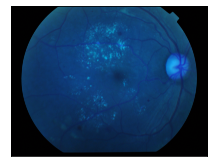

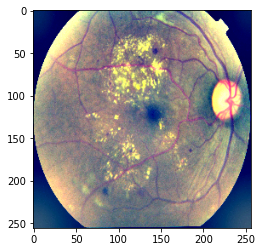

image


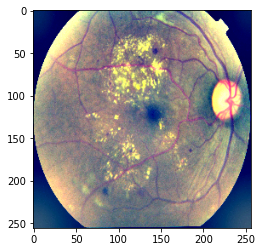

green channel


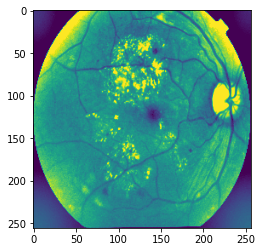

clache


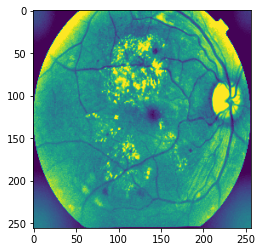

morph 1


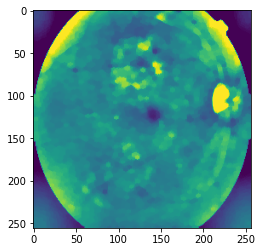

morph 2


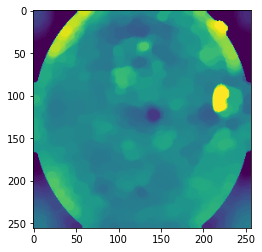

morph 3


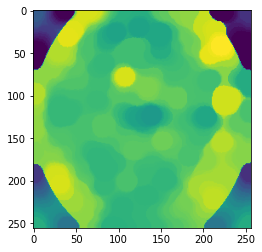

substract from clache 


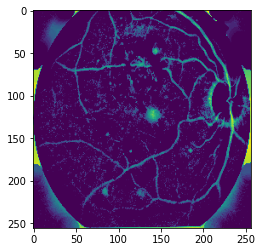

mask


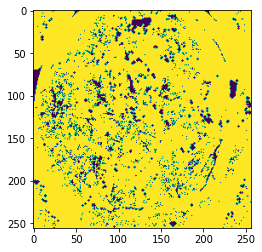

image without noise


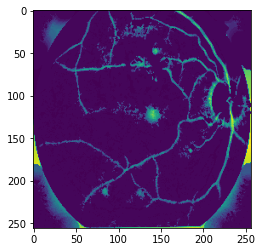

image erosion


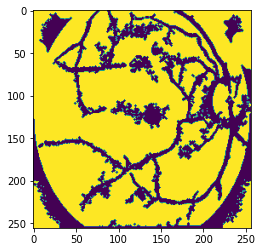

result


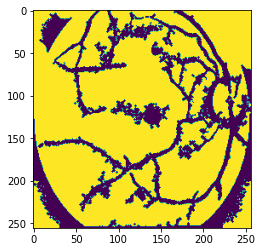

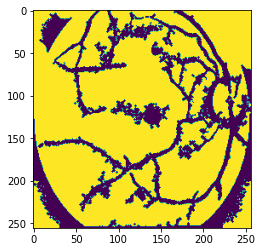

CPU times: total: 6.52 s
Wall time: 6.26 s


In [12]:
%%time

NUM_SAMP=1
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()[:1]):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED+1).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)
        plt.imshow(cv2.imread(path))
        plt.show()
        plt.imshow(image)
        plt.show()
        image =  extract_bv(image)
        plt.imshow(image)
        plt.show()
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

# Detecting Microaneyrismes

In [38]:
def adjust_gamma(image, gamma=1.0):

   
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)
def extract_ma(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    img = load_ben_color(path,sigmaX=30)
    r,g,b=cv2.split(img)
    comp=255-g
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)
    edges = cv2.Canny(J, 70, 35)
    kern = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3),(1,1))
    eye = cv2.dilate(edges, kern, iterations=2)
    eye = cv2.erode(eye, kern, iterations=1)



    params = cv2.SimpleBlobDetector_Params()
    params.minThreshold = 0.4
    params.maxThreshold = 256

    # Set Area filtering parameters
    params.filterByArea = True
    params.maxArea = 40

    params.filterByCircularity = False

    # Set Convexity filtering parameters
    params.filterByConvexity = False
    params.minConvexity = 0.8
        
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(eye)
    blank = np.zeros((1, 1))
    blobs = cv2.drawKeypoints(image, keypoints, blank, (0, 0, 255),
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    number_of_blobs = len(keypoints)
    #print( "Number of Microaneyrisms: " + str(len(keypoints)))
    
    """
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
    
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    """
    return number_of_blobs, blobs

Number of Microaneurisme for image : 15 e580676516b0
Number of Microaneurisme for image : 8 358d2224de73
Number of Microaneurisme for image : 7 c9485c38fdd5
Number of Microaneurisme for image : 11 1d674e2e32e0
Number of Microaneurisme for image : 11 8bc6716c2238
Number of Microaneurisme for image : 10 51131b48f9d4
Number of Microaneurisme for image : 12 b9b99dad668d
Number of Microaneurisme for image : 7 6ea07d19b4ce
Number of Microaneurisme for image : 9 4dd9d29eae5d
Number of Microaneurisme for image : 6 5777ef74c9ec
Number of Microaneurisme for image : 13 a01024054596
Number of Microaneurisme for image : 9 50840c36f0b4
Number of Microaneurisme for image : 10 ca6842bfcbc9
Number of Microaneurisme for image : 9 0a3202889f4d
Number of Microaneurisme for image : 12 6165081b9021
Number of Microaneurisme for image : 9 31cb39681f6a
Number of Microaneurisme for image : 14 e07045d7c5f7
Number of Microaneurisme for image : 12 523b3f0fc646
Number of Microaneurisme for image : 17 ca63fe4f4b52
N

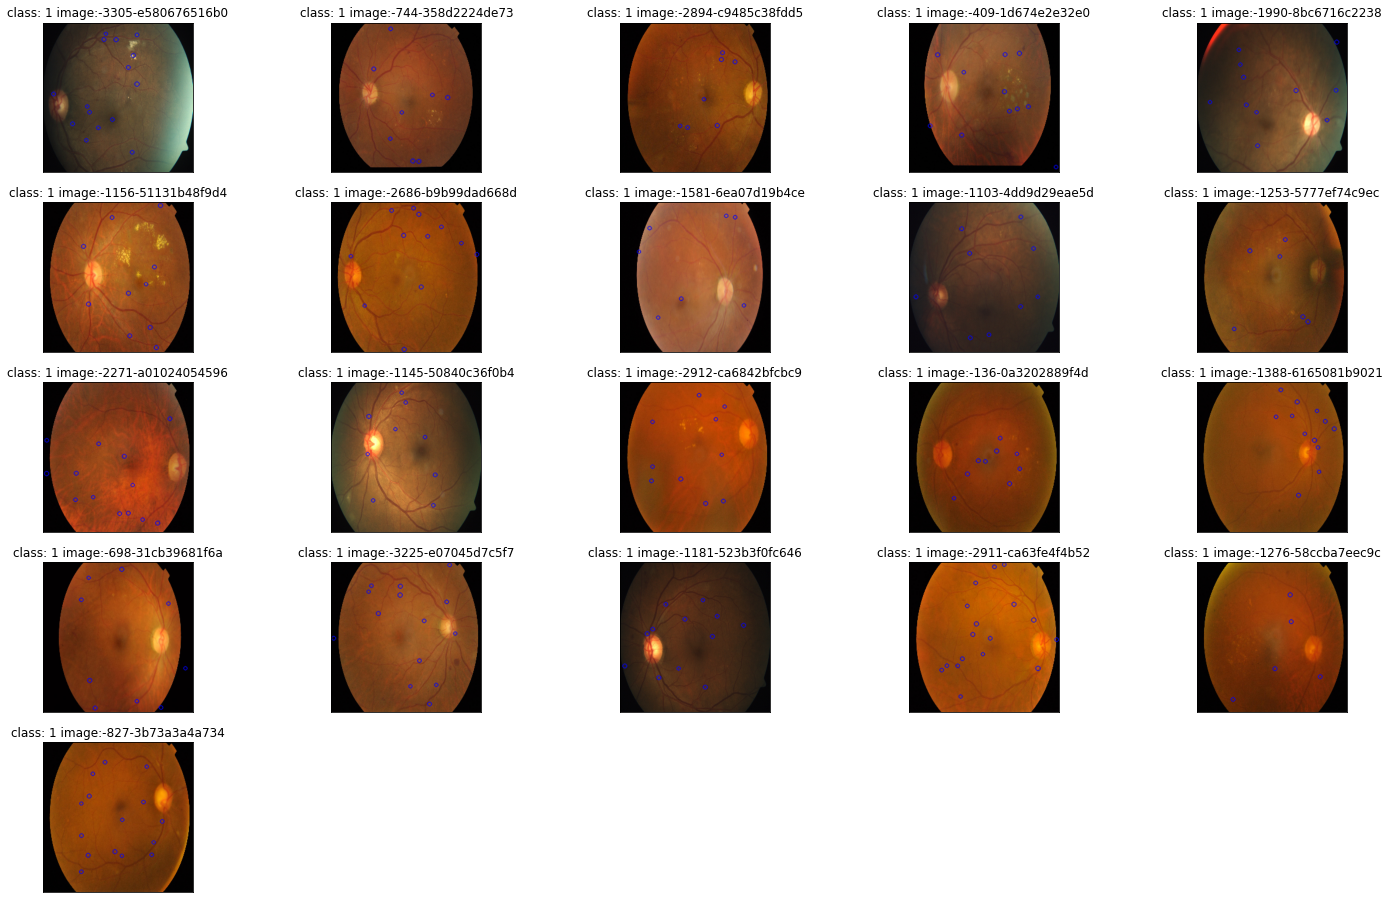

In [39]:
%%time
## Visualisation for class 1
NUM_SAMP=21
fig = plt.figure(figsize=(25, 16))

for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == 1].sample(NUM_SAMP, random_state=SEED).iterrows()):
          ax = fig.add_subplot(5, 5, i+1  , xticks=[], yticks=[])
          path=f"train_images/{row['id_code']}.png"
          num,image =  extract_ma(path)
          plt.imshow(image)
          ax.set_title('class: %d image:-%d-%s' % (1, idx, row['id_code']) )
          print("Number of Microaneurisme for image :", num ,row['id_code'] )

# Detecting Exudats

In [15]:
import math

In [16]:
# same blood vessels detection adapted for exudats detection
def extract_bv(image):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	contrast_enhanced_green_fundus = clahe.apply(image)
	# applying alternate sequential filtering (3 times closing opening)
	r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
	f5 = clahe.apply(f4)

	# removing very small contours through area parameter noise removal
	ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
	mask = np.ones(f5.shape[:2], dtype="uint8") * 255
	contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
	for cnt in contours:
		if cv2.contourArea(cnt) <= 200:
			cv2.drawContours(mask, [cnt], -1, 0, -1)			
	im = cv2.bitwise_and(f5, f5, mask=mask)
	ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
	newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

	# removing blobs of microaneurysm & unwanted bigger chunks taking in consideration they are not straight lines like blood
	# vessels and also in an interval of area
	fundus_eroded = cv2.bitwise_not(newfin)
	xmask = np.ones(image.shape[:2], dtype="uint8") * 255
	xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
	for cnt in xcontours:
		shape = "unidentified"
		peri = cv2.arcLength(cnt, True)
		approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
		if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
			shape = "circle"	
		else:
			shape = "veins"
		if(shape=="circle"):
			cv2.drawContours(xmask, [cnt], -1, 0, -1)	
	
	finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
	blood_vessels = cv2.bitwise_not(finimage)
	dilated = cv2.erode(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations=1)
	#dilated1 = cv2.dilate(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
	blood_vessels_1 = cv2.bitwise_not(dilated)
	return blood_vessels_1


In [17]:
## helper functions

def remove_bv_image(image,bv_image):
	edge_result = image[:,:,0]				
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			if edge_result[i,j] == 255 and bv_image[i,j] == 255:
				edge_result[i,j] = 0
			j = j+1
		i = i+1
	return edge_result



In [18]:


def identify_OD(image):
	newfin = cv2.dilate(image, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations=2)
	mask = np.ones(newfin.shape[:2], dtype="uint8") * 255
	ycontours, yhierarchy = cv2.findContours(newfin.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
	prev_contour = ycontours[0]
	for cnt in ycontours:
		if cv2.contourArea(cnt) >= cv2.contourArea(prev_contour):
			prev_contour = cnt
			cv2.drawContours(mask, [cnt], -1, 0, -1)
	M = cv2.moments(prev_contour)
	cx = int(M['m10']/M['m00'])
	cy = int(M['m01']/M['m00'])	
	return (cx,cy)

def identify_OD_bv_density(blood_vessel_image):
	los = line_of_symmetry(blood_vessel_image)
	sub_image = blood_vessel_image[los-100:los+100,:]
	i = 0
	index = 0
	density = -1
	rr = 0	
	while i < sub_image.shape[1]:
		x1,y1 = sub_image[:,i:i+50].nonzero()
		count = x1.shape[0]		
		if(density < count):
			density = count
			index = i
		i = i + 30	
	print(los,index)
	return (index,los)


def edge_pixel_image(image,bv_image):
	edge_result = image.copy()
	edge_result = cv2.Canny(edge_result,30,100)	
	plt.imshow(edge_result)
	plt.show
 
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			if edge_result[i,j] == 255 and bv_image[i,j] == 255:
				edge_result[i,j] = 0
			j = j+1
		i = i+1
	newfin = cv2.dilate(edge_result, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
	return newfin


In [19]:
OD_data = np.genfromtxt('OD_info.txt', delimiter=',', dtype=None, names=('name','x-coordinate','y-coordinate'))
coordinates = []
name = []	
counterd = 0

for t in OD_data:		
		coordinates.append(t[1].decode("utf-8") + t[2].decode("utf-8"))
		name.append(t[0].decode("utf-8"))
		counterd = counterd + 1

In [20]:
coordinates = [tuple([int(x) for x in coordinate[2:-2].split(' ')]) for coordinate in coordinates]

In [21]:
def remove_suffix(input_string, suffix):
    if suffix and input_string.endswith(suffix):
        return input_string[:-len(suffix)]
    return input_string
names = []
for n in name :
  n= remove_suffix(n,'_resized')
  names.append(n)


In [22]:
pathFolder = "train_images"
filesArray = [x for x in os.listdir(pathFolder) if os.path.isfile(os.path.join(pathFolder,x))]
DestinationFolder = "exudate-detection/"

train_images/001639a390f0 Read this image 001639a390f0
Area Mask: 202104585
(400, 307)


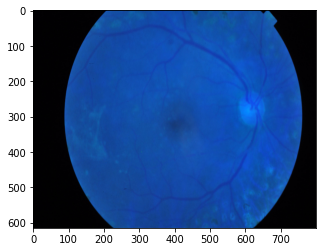

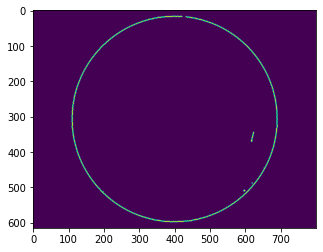

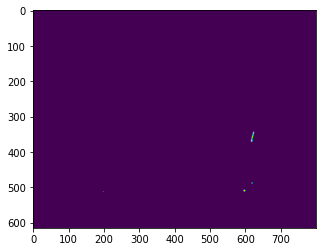

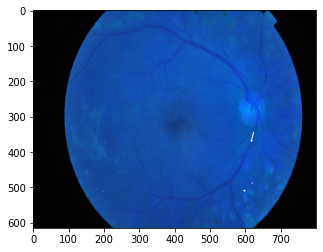

Area of Exdudats:  92565
Area of Eye: 202104585
Percentage of Exdudats:  0.04580054430729516


In [23]:
for file_name in names[1:2]:
        file_name_no_extension = file_name
        coordinates_OD = coordinates[name.index(file_name_no_extension+"_resized")]
        print(pathFolder+'/'+file_name,"Read this image",file_name_no_extension)
        fundus1 = cv2.imread(pathFolder+'/'+file_name+'.png')
        fundus = cv2.resize(fundus1,(800,615))
        fundus_mask = cv2.imread("fmask.bmp")
        fundus_mask = cv2.resize(fundus_mask,(800,615))
        print("Area Mask:",np.sum(fundus_mask))

        edge_mask = cv2.Canny(fundus_mask,30,100)
        edge_mask = cv2.dilate(edge_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations=1)


        f1 = cv2.bitwise_and(fundus[:,:,0],fundus_mask[:,:,0])

        f2 = cv2.bitwise_and(fundus[:,:,1],fundus_mask[:,:,1])
        f3 = cv2.bitwise_and(fundus[:,:,2],fundus_mask[:,:,2])
        fundus_dash = cv2.merge((f1,f2,f3))


        #cv2.imwrite(DestinationFolder+file_name_no_extension+"_resized_fundus.bmp",fundus_dash)
        b,g,r = cv2.split(fundus_dash)
        gray_scale = cv2.cvtColor(fundus_dash,cv2.COLOR_BGR2GRAY)
        print(identify_OD(gray_scale))
        fundus[identify_OD(gray_scale)[0],identify_OD(gray_scale)[1]]=(0, 255, 0)
        plt.imshow( fundus)
        plt.show()
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        contrast_enhanced_fundus = clahe.apply(gray_scale)

        bv_image_dash = extract_bv(g)
        bv_image = extract_bv(gray_scale)

        #cv2.imwrite(DestinationFolder+file_name_no_extension+"_blood_vessels.bmp",bv_image_dash)
        edge_feature_output = edge_pixel_image(gray_scale,bv_image)


        newfin = cv2.dilate(edge_feature_output, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations=1)

        edge_candidates = cv2.erode(newfin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
        edge_candidates = np.uint8(edge_candidates)
        plt.imshow( edge_feature_output)
        plt.show()
        img = cv2.subtract(edge_feature_output, edge_mask)

        #contours,hierchy = cv2.findContours(edge_candidates.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        plt.imshow( img)
        plt.show()
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        res = cv2.add(fundus, img)
        plt.imshow( res)
        plt.show()
        print("Area of Exdudats: ",np.sum(img))
        print("Area of Eye:",np.sum(fundus_mask))
        print("Percentage of Exdudats: ",(np.sum(img)/np.sum(fundus_mask))*100)